In [1]:
import braintracer.file_management as btf

In [2]:
btf.verify_image_integrity('SC016')

Channel 1 successfully verified.
Channel 2 successfully verified.
Channel 3 successfully verified.


In [3]:
name = 'SC016'
channel_to_stitch = '3'
# keep a backup of the original data in another directory
# ensure folders named {name}_i and {name}_ii are present in the working directory
# these should have folders of images named {channel_to_stitch}

In [4]:
import os, glob, cv2, shutil
import matplotlib.pyplot as plt
from skimage.io import imread_collection, imsave
import numpy as np
from tqdm import tqdm

In [5]:
wdir = os.getcwd()
dir1 = os.path.join(wdir, name+'_1') # 1 is 5046 x 3417
dir2 = os.path.join(wdir, name+'_2') # 2 is 5137 x 3598
ims_path1 = os.path.join(dir1, channel_to_stitch, '*.tif')
ims_path2 = os.path.join(dir2, channel_to_stitch, '*.tif')
ims1 = imread_collection(ims_path1)
ims2 = imread_collection(ims_path2)
im_list1 = list(sorted(glob.glob(ims_path1)))
im_list2 = list(sorted(glob.glob(ims_path2))) # add catch case for when path incorrect

In [6]:
end_section1 = cv2.imread(im_list1[-1], 0) # get the two images separating the two halves
start_section2 = cv2.imread(im_list2[0], 0) # read images with conversion to 8-bit (0) for template matching
print(end_section1.shape, start_section2.shape)

if end_section1.size > start_section2.size: # get the template and background
    big, sml = end_section1, start_section2
    stack_to_pad, save_dir = ims2, dir2
elif end_section1.size < start_section2.size:
    big, sml = start_section2, end_section1
    stack_to_pad, save_dir = ims1, dir1
else:
    print('No alignment required. Both stack halves are identical')
assert big.shape[0] > sml.shape[0] and big.shape[1] > sml.shape[1], 'Cannot find image inside other. Template is not smaller than image in both dimensions.'

(3845, 5777) (4390, 6261)


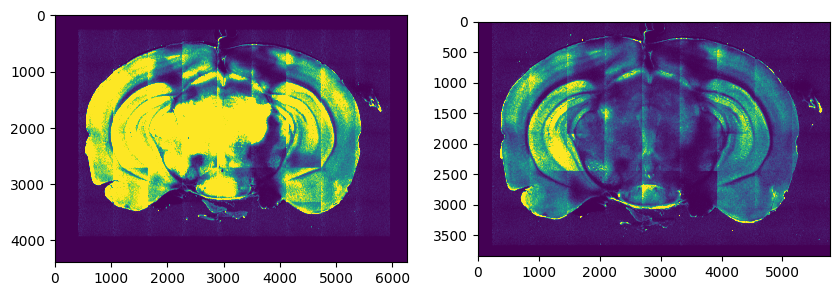

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1.imshow(big, vmax=2)
ax2.imshow(sml, vmax=2)

Coordinates: (179, 248)


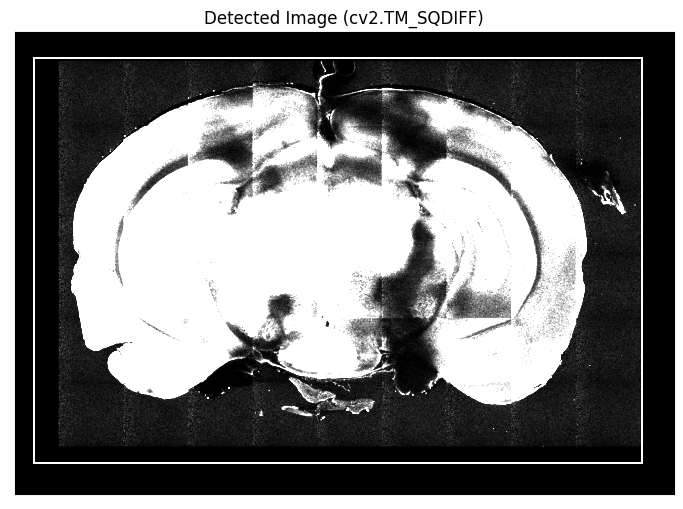

In [8]:
big_working = big.copy()
m = 'cv2.TM_SQDIFF'
res = cv2.matchTemplate(big_working, sml, eval(m)) # Apply template
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
top_left = min_loc # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
bottom_right = (top_left[0] + sml.shape[1], top_left[1] + sml.shape[0]) # add the height and width to the top_left coords
cv2.rectangle(big_working, top_left, bottom_right, 255, 2)

f, ax = plt.subplots(figsize=(15,6))
ax.imshow(big_working, cmap = 'gray', vmax=1)
ax.set_title(f'Detected Image ({m})'), plt.xticks([]), plt.yticks([]);
print(f'Coordinates: {top_left}')

In [9]:
top_left, bottom_right = top_left[::-1], bottom_right[::-1] # pad the smaller image with zeros up to the size of the big image
top_pad, bottom_pad = top_left[0], big.shape[0] - bottom_right[0]
left_pad, right_pad = top_left[1], big.shape[1] - bottom_right[1]
print(top_pad, bottom_pad, left_pad, right_pad)

248 297 179 305


In [10]:
for i in tqdm(range(len(stack_to_pad))):
    img = stack_to_pad[i]
    pad_img = np.pad(img, ((top_pad, bottom_pad), (left_pad, right_pad)), 'constant')
    
    dir_path = os.path.join(save_dir, channel_to_stitch)
    fname = [n for _, _, n in os.walk(dir_path, topdown=True)][0][i] # get the original file name
    save_path = os.path.join(save_dir, f'{channel_to_stitch}_pad')
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    dest = os.path.join(save_path, fname)
    imsave(dest, pad_img, plugin='tifffile', check_contrast=False)

100%|█████████████████| 1216/1216 [09:00<00:00,  2.25it/s]


In [11]:
def dir_empty(dir_name):
    if os.path.isdir(dir_name):
        if not os.listdir(dir_name):
            print("Directory is empty")
            return True
        else:    
            print("Directory is not empty")
            return False
    else:
        print("Given directory doesn't exist")
        return True

def offset_file_num(in_dir, by):
    for root, dirs, files in os.walk(in_dir, topdown=True): # topdown is essential for file renaming - it steps in reverse order so that files are not overwritten
        #files = list(files.sort(reverse=True))
        for file in reversed(files):
            og_num = int(file.split('_')[1])
            new_num = og_num + by
            og_slice = file.split('_')[-1]
            new_name = f'section_{new_num}_{og_slice}'
            os.rename(os.path.join(in_dir, file), os.path.join(in_dir, new_name))

def organise_files(subdir, spath):
    dirs = [d for _, d, _ in os.walk(subdir, topdown=True)][0]
    if f'{channel_to_stitch}_pad' in dirs:
        dir_to_copy = os.path.join(subdir, f'{channel_to_stitch}_pad')
    else:
        dir_to_copy = os.path.join(subdir, channel_to_stitch)
    end_path = os.path.join(spath, channel_to_stitch)
    
    if subdir == dir1: # copy folder for first round
        if not dir_empty(dir_to_copy):
            shutil.move(dir_to_copy, end_path) # move: folder moved also
            #os.rmdir(dir_to_copy)
        
    elif subdir == dir2: # rename files based on maximum dir1 name
        last_im1_name = [n for _, _, n in os.walk(end_path, topdown=True)][0][-1] # check dest path because dir1 is moved before dir2
        max_stack1_num = int(last_im1_name.split('_')[1])
        offset_file_num(dir_to_copy, max_stack1_num)
        
        for _, _, files in os.walk(dir_to_copy, topdown=True): # topdown is essential for file renaming - it steps in reverse order so that files are not overwritten
            for file in reversed(files):
                shutil.move(os.path.join(dir_to_copy, file), os.path.join(end_path, file))
        #os.rmdir(dir_to_copy)
    #shutil.rmtree(subdir)

save_path = os.path.join(wdir, name)
if not os.path.isdir(save_path):
    os.makedirs(save_path)
organise_files(dir1, save_path)
organise_files(dir2, save_path)

Directory is not empty
